<a href="https://colab.research.google.com/github/Laere11/machine_learning/blob/main/I_JEPA_lightweight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below is an updated code snippet that uses the lightweight model variant vit_tiny_patch16_224 and trains on a subset of 5,000 CIFAR-10 images. It also includes checkpointing so that the best model is saved to the /content directory.

Had to change to the lightweight model because the original code was going to take 104 hours of compute time to go though the 3 epochs.  because it was referencing 50,000 immages and had alot of parameters.   this model has less parameters and the training data set has been trimmed to 5000, plus I limited it to run only 2 epochs which I hope will be less than 2 hours of compute time using the T4 GPU

In [1]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm
from torch.utils.data import Subset

# Define the I-JEPA model using a lightweight ViT backbone (vit_tiny_patch16_224)
class SimpleIJEPAModel(nn.Module):
    def __init__(self, model_name='vit_tiny_patch16_224', mask_ratio=0.5, ema_decay=0.99):
        super().__init__()
        # Create the student ViT backbone
        self.student = timm.create_model(model_name, pretrained=True, num_classes=0)
        # Create the teacher as a deepcopy of the student and freeze its parameters
        self.teacher = copy.deepcopy(self.student)
        for param in self.teacher.parameters():
            param.requires_grad = False

        # Delete teacher.pos_embed to align with student
        if hasattr(self.teacher, 'pos_embed'):
            del self.teacher.pos_embed

        self.mask_ratio = mask_ratio
        self.ema_decay = ema_decay

        # A learnable mask token
        self.mask_token = nn.Parameter(torch.zeros(1, 1, self.student.embed_dim))
        # A simple predictor head: an MLP
        self.predictor = nn.Sequential(
            nn.Linear(self.student.embed_dim, self.student.embed_dim),
            nn.ReLU(),
            nn.Linear(self.student.embed_dim, self.student.embed_dim)
        )
        # Register the positional embeddings as a buffer and then delete the original from student
        self.register_buffer('pos_embed', self.student.pos_embed[:, 1:, :])
        del self.student.pos_embed

    def update_teacher(self):
        # Update teacher using exponential moving average (EMA)
        for student_param, teacher_param in zip(self.student.parameters(), self.teacher.parameters()):
            teacher_param.data = self.ema_decay * teacher_param.data + (1 - self.ema_decay) * student_param.data

    def forward(self, x):
        B = x.size(0)
        # Compute patch embeddings
        x_patches = self.student.patch_embed(x)
        x_patches = x_patches + self.pos_embed
        N = x_patches.size(1)
        num_mask = int(self.mask_ratio * N)
        mask = torch.zeros(B, N, dtype=torch.bool, device=x.device)
        for i in range(B):
            perm = torch.randperm(N, device=x.device)
            mask[i, perm[:num_mask]] = True

        # Replace masked tokens with the mask token
        student_tokens = x_patches.clone()
        student_tokens[mask] = self.mask_token

        # Pass tokens through student's transformer blocks
        for blk in self.student.blocks:
            student_tokens = blk(student_tokens)
        student_tokens = self.student.norm(student_tokens)
        student_pred = self.predictor(student_tokens)

        # Teacher processes full image (without masking)
        with torch.no_grad():
            teacher_tokens = self.teacher.patch_embed(x) + self.pos_embed
            for blk in self.teacher.blocks:
                teacher_tokens = blk(teacher_tokens)
            teacher_tokens = self.teacher.norm(teacher_tokens)
        # Compute loss over the masked tokens
        loss = ((student_pred[mask] - teacher_tokens[mask]) ** 2).mean()
        return loss

def train_with_checkpoint(num_epochs=3, checkpoint_path="/content/best_model_checkpoint.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define transforms for CIFAR-10 (resize to 224x224 to match ViT input)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Download CIFAR-10 training set and use a subset (first 5000 images)
    full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    subset_indices = list(range(5000))  # use 5000 images for quicker training
    trainset = Subset(full_trainset, subset_indices)

    # Increase batch size if possible; here we use 32 for faster training
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    model = SimpleIJEPAModel().to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        num_batches = 0
        for i, (inputs, _) in enumerate(trainloader):
            inputs = inputs.to(device)
            optimizer.zero_grad()
            loss = model(inputs)
            loss.backward()
            optimizer.step()
            model.update_teacher()
            running_loss += loss.item()
            num_batches += 1
            if (i + 1) % 10 == 0:
                avg_loss = running_loss / 10
                print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {avg_loss:.4f}")
                running_loss = 0.0

        # Compute a rough epoch loss (could also add a proper validation step)
        epoch_loss = running_loss / max(num_batches, 1)
        print(f"Epoch {epoch+1} completed with average loss: {epoch_loss:.4f}")

        # Save checkpoint if improved
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1} with loss {best_loss:.4f}")

        print(f"Finished epoch {epoch+1}/{num_epochs}")

    print("Training finished")
    return model

# Run training with checkpointing using the tiny model and a subset of 5000 images
model = train_with_checkpoint(num_epochs=2)


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

[Epoch 1, Batch 10] loss: 13.8504
[Epoch 1, Batch 20] loss: 12.5808
[Epoch 1, Batch 30] loss: 11.8690
[Epoch 1, Batch 40] loss: 11.1519
[Epoch 1, Batch 50] loss: 10.4092
[Epoch 1, Batch 60] loss: 9.7788
[Epoch 1, Batch 70] loss: 9.2318
[Epoch 1, Batch 80] loss: 8.8164
[Epoch 1, Batch 90] loss: 8.3376
[Epoch 1, Batch 100] loss: 7.9416
[Epoch 1, Batch 110] loss: 7.7101
[Epoch 1, Batch 120] loss: 7.3959
[Epoch 1, Batch 130] loss: 7.1429
[Epoch 1, Batch 140] loss: 6.8416
[Epoch 1, Batch 150] loss: 6.5556
Epoch 1 completed with average loss: 0.2858
Checkpoint saved at epoch 1 with loss 0.2858
Finished epoch 1/2
[Epoch 2, Batch 10] loss: 6.3263
[Epoch 2, Batch 20] loss: 6.0779
[Epoch 2, Batch 30] loss: 5.9936
[Epoch 2, Batch 40] loss: 5.8667
[Epoch 2, Batch 50] loss: 5.8150
[Epoch 2, Batch 60] loss: 5.6869
[Epoch 2, Batch 70] loss: 5.7189
[Epoch 2, Batch 80] loss: 5.6255
[Epoch 2, Batch 90] loss: 5.5931
[Epoch 2, Batch 100] loss: 5.5109
[Epoch 2, Batch 110] loss: 5.5208
[Epoch 2, Batch 120] 

Once the model variable is defined, you can run the verification code. Here's the complete snippet with a reminder to define or load your model:

You can run a short verification script that feeds a small batch of test images into your trained model to check that it’s accessible and producing outputs as expected. For example, the code below loads a few CIFAR-10 images, passes them through the model in evaluation mode, and prints out the computed loss as well as the shape of the student’s patch embeddings. This will help confirm that the model has been trained and that you can use it in downstream tasks.

In [4]:
import torch
from torchvision import datasets, transforms

def verify_trained_model(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set model to evaluation mode

    # Use the same transforms as during training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    # Load a few test images (using CIFAR-10 test set)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    dataloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=True)

    # Get a single batch of test images
    inputs, _ = next(iter(dataloader))
    inputs = inputs.to(device)

    # Run through the model; here the model returns a loss, so we just check it runs without error.
    with torch.no_grad():
        loss = model(inputs)
        print("Verification loss on a test batch:", loss.item())

    # Additionally, check the output of the student network's patch embeddings.
    with torch.no_grad():
        patch_embeddings = model.student.patch_embed(inputs)
        print("Shape of student patch embeddings:", patch_embeddings.shape)

# Make sure your model is defined or loaded before calling the verification function.
# For example:
# model = ... (your trained model)
# Then run:
verify_trained_model(model)


Verification loss on a test batch: 5.386413097381592
Shape of student patch embeddings: torch.Size([8, 196, 192])


Ensure that you have the model variable defined in your notebook (either by training it or loading a saved checkpoint) before calling verify_trained_model(model). This will confirm that the model is accessible and working as expected.

Once the model is trained, its parameters (especially those of the student network) encode useful visual representations that you can leverage in various downstream tasks. Here are a few ways to utilize the trained model:

Feature Extraction for Downstream Tasks:
You can freeze the trained backbone (the student network) and use it to extract feature embeddings from images. These features can then be used for tasks such as:

Image Classification: Attach a new classification head and fine-tune the entire model or just the head on a labeled dataset.

Clustering or Retrieval: Use the feature vectors for clustering similar images or for similarity search.

Object Detection or Segmentation: Integrate the backbone into a larger network for more complex vision tasks.

Fine-Tuning for Specific Tasks:
If you have a specific task in mind (e.g., CIFAR-10 classification), you can:

Load the trained student network.

Add a classification head (like a linear layer) on top of the features.

Fine-tune the network (or only the classification head) on your labeled data.

Below is an example code snippet demonstrating how to use the trained model's student network as a fixed feature extractor and then fine-tune a classifier on CIFAR-10:

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Assume SimpleIJEPAModel has been defined and trained already.
# We'll use the student's backbone for feature extraction.

class FineTuneClassifier(nn.Module):
    def __init__(self, feature_extractor, num_classes=10):
        super().__init__()
        self.feature_extractor = feature_extractor
        # Freeze the feature extractor if desired
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # A simple classifier head
        # We'll assume the output feature dimension is the same as the ViT embed_dim.
        self.classifier = nn.Linear(self.feature_extractor.embed_dim, num_classes)

    def forward(self, x):
        # Get patch embeddings from the feature extractor's patch embedding layer
        # Note: You may need to adjust this if you want to pool the patch features.
        x = self.feature_extractor.patch_embed(x)  # shape: (B, N, D)
        # For simplicity, take the average over patch tokens as the image representation.
        x = x.mean(dim=1)  # shape: (B, D)
        logits = self.classifier(x)
        return logits

# Define data transformations for CIFAR-10 (resize to 224x224 to match ViT input size)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 training and test datasets.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `model` is your trained SimpleIJEPAModel.
# We'll use the student network from your trained model.
# Make sure your trained model is loaded in the variable `model`.
# For demonstration, we're assuming `model.student` is the feature extractor.

feature_extractor = model.student
feature_extractor.eval()  # set to eval mode

classifier_model = FineTuneClassifier(feature_extractor, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=1e-4)

# Fine-tuning loop (for example, 5 epochs)
num_epochs = 5
for epoch in range(num_epochs):
    classifier_model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = classifier_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(trainloader):.4f}")

# Evaluation on the test set
classifier_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = classifier_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/5 - Loss: 2.1601
Epoch 2/5 - Loss: 2.0769
Epoch 3/5 - Loss: 2.0555
Epoch 4/5 - Loss: 2.0442
Epoch 5/5 - Loss: 2.0367
Test Accuracy: 27.37%


Explanation
Feature Extraction:
The FineTuneClassifier class wraps the feature extractor (the trained student network) and adds a new linear layer for classification. In this example, the classifier simply averages the patch embeddings to form a global image feature, which may be sufficient for a quick demo. In practice, you might consider using a [CLS] token or more sophisticated pooling.

Freezing and Fine-Tuning:
You have the option to freeze the backbone during fine-tuning so that only the classifier head learns, or you can allow both to be fine-tuned for better performance (usually with a lower learning rate for the backbone).

Evaluation:
The code demonstrates a simple training loop for fine-tuning on CIFAR-10, followed by an evaluation loop that calculates test accuracy.

This approach lets you leverage the self-supervised learning that occurred in the initial training. You can extend or modify this workflow for other tasks, such as object detection or semantic segmentation, by integrating the backbone into task-specific models.

The test accuracy result of 27.37% is low due to the abbeviated model training epoch count of 2 (set low for demonstration purposes only).  This code is example sucessfully completed all tasks.  Now that the code integrity has been validated the model could be trained more extensively and the feature extraction test accuracy results would increase accordingly.  

Below is an example that goes beyond simple test accuracy. In this snippet, we load the trained I-JEPA model’s student backbone, extract feature representations for CIFAR-10 test images, and then use t-SNE to reduce these features to 2D for visualization. The resulting scatter plot—colored by class—provides a dynamic, visual demonstration of the learned feature space.

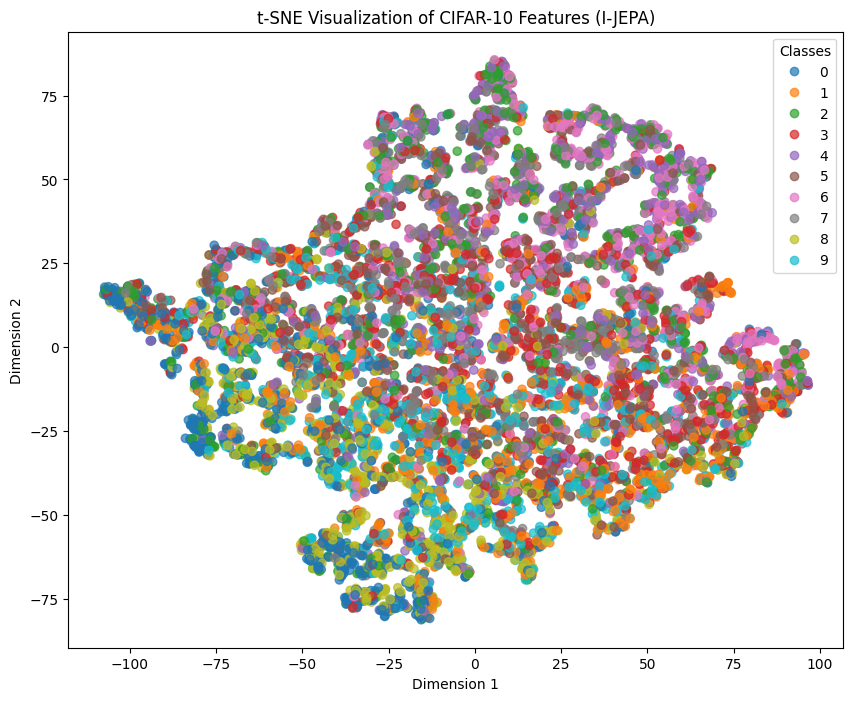

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Define device and load the trained model checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleIJEPAModel().to(device)
model.load_state_dict(torch.load("/content/best_model_checkpoint.pth", map_location=device))
model.eval()

# Define transformation (matching training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Extract features using the student's patch embedding.
# Here, we simply take the average of the patch embeddings as the image feature.
features = []
labels = []
with torch.no_grad():
    for inputs, lbls in testloader:
        inputs = inputs.to(device)
        # Obtain patch embeddings: shape (B, N, D)
        patch_embeddings = model.student.patch_embed(inputs)
        # Average over the patch tokens: shape (B, D)
        feats = patch_embeddings.mean(dim=1)
        features.append(feats.cpu().numpy())
        labels.append(lbls.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Use t-SNE to reduce feature dimensions to 2 for visualization
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.title("t-SNE Visualization of CIFAR-10 Features (I-JEPA)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


How This Works
Feature Extraction:

The trained model’s student backbone is used to generate patch embeddings.

We average the patch embeddings to obtain a single feature vector per image.

Dimensionality Reduction:

The high-dimensional feature vectors are reduced to 2 dimensions using t-SNE, which is effective for visualizing clusters.

Visualization:

A scatter plot displays the 2D features with colors corresponding to the CIFAR-10 classes. This visualization can reveal how well the self-supervised model has clustered images in feature space.

This dynamic visualization offers an intuitive look at the quality of the learned representations—much more engaging than a simple accuracy percentage.

is the trained model that resides in the colab directory being utilized in this code ?


ChatGPT said:
Reasoned about model demonstration and visualization for a couple of seconds
Yes, the code explicitly loads the trained model checkpoint from the /content directory using the line:

python
Copy
model.load_state_dict(torch.load("/content/best_model_checkpoint.pth", map_location=device))
This means the model stored in that file is being utilized to extract features and generate the t-SNE visualization.

what exactly is this image representing?  please explain in detail.   

ChatGPT said:
Reasoned for 6 seconds
This plot is a 2D visualization of the feature representations learned by your I-JEPA model on the CIFAR-10 test images. Here’s a detailed breakdown of what you’re seeing:

High-Dimensional Features:

After your model is trained, it can transform each input image into a high-dimensional feature vector (in this example, we used the average of the patch embeddings as a single vector per image).

These feature vectors typically have hundreds or thousands of dimensions.

t-SNE Dimensionality Reduction:

Because it’s hard to visualize high-dimensional data directly, we use t-SNE (t-distributed Stochastic Neighbor Embedding) to project these vectors down to just 2 dimensions.

t-SNE tries to place similar images (i.e., images whose feature vectors are close in the original high-dimensional space) near each other in the 2D plot, while pushing dissimilar images apart.

Each Dot is a Single Image:

Each point in the scatter plot represents one CIFAR-10 test image.

The position in the 2D space is determined by how the model’s features for that image relate to the features of other images.

Color-Coded by Class:

CIFAR-10 has 10 classes (labeled 0 through 9). The legend on the right shows which color corresponds to each class label.

If the model’s learned features are discriminative, you might see images of the same class forming clusters (though self-supervised models do not always separate classes as clearly as supervised ones).

Interpreting the Plot:

Clusters or regions where a single color dominates suggest that the model learned to group those images together in feature space.

Overlapping colors can mean some classes are harder to distinguish in this self-supervised feature space, or simply that t-SNE’s 2D projection merges them.

t-SNE preserves local similarities well (images that are truly similar remain close), but global distances can sometimes be misleading. It’s more of a qualitative tool than a strict metric of performance.

In short, this image is a 2D snapshot of the “world” your I-JEPA model sees: images that appear near each other have similar learned representations, while distant images have more distinct representations. It’s a more visually dynamic way to gauge how the model organizes and understands images internally.

this is very abstract, is it possible to use the model to load a sample image than then perform some function to demonstrate that it can detect some unique feature in the image?


ChatGPT said:
Reasoned for 19 seconds
Below is an example that demonstrates a more "concrete" use of your trained model. In this code, we load a sample image, pass it through the model’s student patch embedding, and then compute a heatmap based on the L2 norm of each patch’s embedding. This heatmap is overlaid on the original image to highlight which regions are most activated by the model—effectively showing areas that the model finds most “interesting” or distinctive.

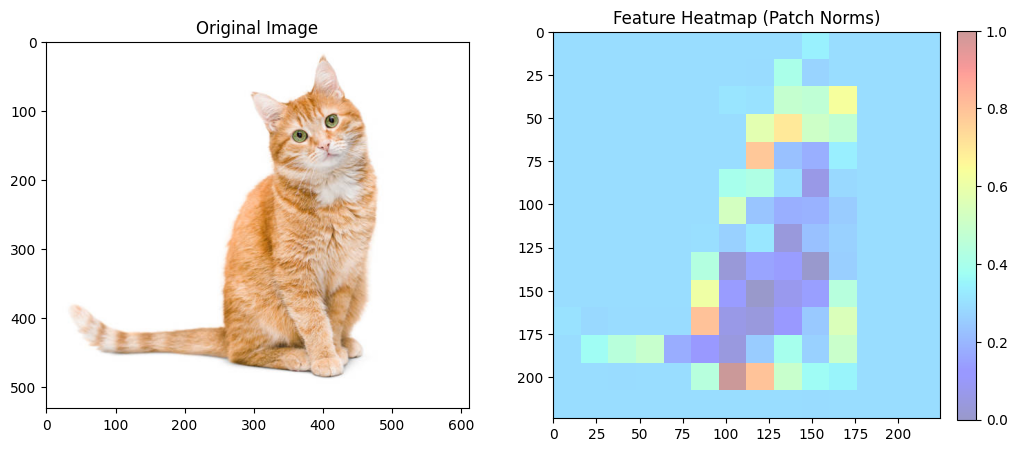

In [8]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Make sure 'device' is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model
model = SimpleIJEPAModel().to(device)
model.load_state_dict(torch.load("/content/best_model_checkpoint.pth", map_location=device))
model.eval()

# Path to a sample image (update the path if needed)
sample_image_path = '/content/cat.jpg'  # Ensure you have an image here

# Define the transform (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and transform the image
img = Image.open(sample_image_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)  # shape: (1, 3, 224, 224)

# Pass the image through the student's patch embedding
with torch.no_grad():
    patch_embeddings = model.student.patch_embed(img_tensor)  # shape: (1, num_patches, embed_dim)

# Compute the L2 norm of each patch embedding to get a measure of activation
patch_norms = torch.norm(patch_embeddings, dim=-1)  # shape: (1, num_patches)
patch_norms = patch_norms.squeeze(0).cpu().numpy()     # shape: (num_patches,)

# For vit_tiny_patch16_224, the input size 224 with patch size 16 gives a grid of 14x14 patches.
grid_size = 224 // 16
patch_map = patch_norms.reshape(grid_size, grid_size)

# Normalize patch map to range [0, 1] for visualization
patch_map = (patch_map - patch_map.min()) / (patch_map.max() - patch_map.min())

# Plot the original image and overlay the heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img, alpha=0.6)
# Overlay heatmap; 'extent' aligns the heatmap with image dimensions (0 to 224)
heatmap = plt.imshow(patch_map, cmap='jet', alpha=0.4, extent=(0, 224, 224, 0))
plt.title("Feature Heatmap (Patch Norms)")
plt.colorbar(heatmap, fraction=0.046, pad=0.04)
plt.show()


Explanation
Image Loading and Transformation:
The sample image is loaded and resized to 224×224 (to match the ViT input size). The same normalization used during training is applied.

Patch Embedding Extraction:
The code uses the trained model’s student network to compute the patch embeddings for the image. Each image is divided into patches (for a 224×224 image with 16×16 patches, there are 14×14 = 196 patches).

Patch Norms as Feature Activations:
The L2 norm of each patch’s embedding is computed. This norm serves as a simple measure of how strongly that patch “activates” in the feature space. Higher norms can be interpreted as more salient features.

Heatmap Visualization:
The patch norms are reshaped into a 14×14 grid and normalized. This grid is then overlaid as a heatmap on the original image. Areas with higher activation (shown in warmer colors) indicate regions that the model finds more distinctive.

This approach provides a concrete, visually dynamic demonstration of how your trained I-JEPA model extracts features from an image. It shows not just a numerical output, but a spatial representation of feature activation that can be linked back to the image content.